In [14]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stat
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import math
from tabulate import tabulate
import seaborn as sns
import hashlib
pd.set_option('display.max_rows', None)

In [53]:
path = input('Enter full path to human-ai-race directory e.g. /Users/foo/foo/human-ai-race/Quantitative\ Analysis/:\n')
os.chdir(path)

Enter full path to human-ai-race directory e.g. /Users/foo/foo/human-ai-race/Quantitative\ Analysis/:
PATH HERE

In [91]:
prolific = pd.read_csv('Prolific_Data.csv')
pid_list = prolific.PROLIFIC_PID.to_list()


In [92]:
#this gets all of the seperate pavlovia files, compares them to the prolific ids and drops all of the partial runs
#then it drops the practice trials and the attention check trials
files = glob.glob('pav_data/*.csv')
pav_list = []
i = 0
while i < len(files):
    temp = pd.read_csv(files[i])
    i += 1
    if len(temp) == 15 and temp.PROLIFIC_PID[1] in pid_list:
        temp.drop([0,1,2,7],inplace=True)
        pav_list.append(temp)
    else:
        pass

In [93]:
#this checks to make sure there aren't multiple complete runs for the same participant. this happened a few times due to pavlovia errors
#if anything prints here, check the files and make sure any duplicates or extra runs are removed
j = 0
find_dup = {}
while j < len(pav_list):
    if pav_list[j].PROLIFIC_PID[3] in find_dup:
        find_dup[pav_list[j].PROLIFIC_PID[3]] += 1
    else:
        find_dup[pav_list[j].PROLIFIC_PID[3]] = 1
    j += 1

for key in find_dup:
    if find_dup[key] > 1:
        print(key)
# print(len(find_dup))


In [94]:
#This sorts the pavlovia data out by treatment group and demographic
pav_gBdB = []
pav_gWdB = []
pav_gBdW = []
pav_gWdW = []
pav_gGdB = []
pav_gGdW = []
i = 0
while i < len(pav_list):
    index = prolific.loc[(prolific.PROLIFIC_PID == pav_list[i].PROLIFIC_PID[3])].index
    ind = index[0]
    demo = prolific.at[ind,'Demographic']
    group = prolific.at[ind,'GROUP']
    if group == 'Black' and demo == 'Black/African American':
        pav_gBdB.append(temp)
    elif group == 'Black' and demo == 'White/Caucasian':
        pav_gBdW.append(temp)
    elif group == 'White' and demo == 'Black/African American':
        pav_gWdB.append(temp)
    elif group == 'White' and demo == 'White/Caucasian':
        pav_gWdW.append(temp)
    elif group == 'General' and demo == 'Black/African American':
        pav_gGdB.append(temp)
    elif group == 'General' and demo == 'White/Caucasian':
        pav_gGdW.append(temp)
    else:
        pass
    i += 1


In [9]:
#this gives arrays of just the final score for each participant split by treatment group and demographic
final_score_gBdB = []
final_score_gBdW = []
final_score_gWdW = []
final_score_gWdB = []
final_score_gGdW = []
final_score_gGdB = []
key = ['Black/African American','Black/African American',
      'Black/African American', 'White/Caucasian',
      'White/Caucasian', 'Black/African American',
      'White/Caucasian','White/Caucasian',
      'General','Black/African American',
      'General','White/Caucasian']
for df in pav_gBdB:
    final_score_gBdB.append(df.Score[14])
    
for df in pav_gBdW:
    final_score_gBdW.append(df.Score[14])

for df in pav_gWdW:
    final_score_gWdW.append(df.Score[14])

for df in pav_gWdB:
    final_score_gWdB.append(df.Score[14])
    
for df in pav_gGdW:
    final_score_gGdW.append(df.Score[14])
    
for df in pav_gGdB:
    final_score_gGdB.append(df.Score[14])
    
final_scores = [final_score_gBdB,final_score_gBdW,final_score_gWdB,final_score_gWdW,final_score_gGdB,final_score_gGdW]
output = []
headers = ['Treatment Group','Demographic','mean','median','ci95_lo','ci95_hi']
k = 0
l=1
while k < len(final_scores):
    m = np.mean(final_scores[k])
    med = np.median(final_scores[k])
    c = len(final_scores[k])
    s = np.std(final_scores[k])
    output.append([key[l-1],key[l],m,med,(m - 1.96*s/math.sqrt(c)),(m + 1.96*s/math.sqrt(c))])
    k += 1
    l+=2

print(tabulate(output,headers=headers,tablefmt='github'))

| Treatment Group        | Demographic            |     mean |   median |   ci95_lo |   ci95_hi |
|------------------------|------------------------|----------|----------|-----------|-----------|
| Black/African American | Black/African American | 22.6129  |     18   |  -5.16686 |   50.3927 |
| Black/African American | White/Caucasian        | 24.125   |     22   |  -1.19189 |   49.4419 |
| White/Caucasian        | Black/African American | 12.2581  |     20   |  -8.60932 |   33.1254 |
| White/Caucasian        | White/Caucasian        | 39.1     |     44.5 |  11.1558  |   67.0442 |
| General                | Black/African American |  8.90323 |     24   | -22.4941  |   40.3006 |
| General                | White/Caucasian        | 62.5667  |     56   |  38.0712  |   87.0622 |


In [113]:
#this concatenates all the dataframes into one dataframe, it makes things easier
def concat_df(data):
    first = data[0]
    for df in data[1:]:
      first = pd.concat([first,df])
    return first

def pivots(concat):
    pivot = pd.melt(concat, id_vars=['trials.thisRepN','PROLIFIC_PID'],value_vars=['Score']) #This gives a running total of the score, the resulting plot has a new line per participant
    score = pd.melt(concat, id_vars=['trials.thisRepN'],value_vars=['Points scored this round']) #This gives just the points scored per round
    method = pd.melt(concat, id_vars=['Method of Scoring', 'Score','trials.thisN'],value_vars=['Points scored this round']) # This gives the scoring method so we can make pie plots.
    return pivot,score,method

def get_final_score(data):
    final_scores = pd.DataFrame(columns=['trials.thisRepN','PROLIFIC_PID','variable','value'])
    for i,row in data.iterrows():
        trial = row['trials.thisRepN']
        if trial == 14:
            final_scores = final_scores.append(row)
        else:
            pass
    return final_scores

concat_gBdB = concat_df(pav_gBdB)
concat_gBdW = concat_df(pav_gBdW)
concat_gWdB = concat_df(pav_gWdB)
concat_gWdW = concat_df(pav_gWdW)
concat_gGdB = concat_df(pav_gGdB)
concat_gGdW = concat_df(pav_gGdW)


pivot_gBdB, score_gBdB, method_gBdB = pivots(concat_gBdB)
pivot_gBdW, score_gBdW, method_gBdW = pivots(concat_gBdW)
pivot_gWdB, score_gWdB, method_gWdB = pivots(concat_gWdB)
pivot_gWdW, score_gWdW, method_gWdW = pivots(concat_gWdW)
pivot_gGdB, score_gGdB, method_gGdB = pivots(concat_gGdB)
pivot_gGdW, score_gGdW, method_gGdW = pivots(concat_gGdW)

final_gBdB = get_final_score(pivot_gBdB)
final_gBdW = get_final_score(pivot_gBdW)
final_gWdB = get_final_score(pivot_gWdB)
final_gWdW = get_final_score(pivot_gWdW)
final_gGdB = get_final_score(pivot_gGdB)
final_gGdW = get_final_score(pivot_gGdW)

final_gBdB = final_gBdB.assign(GROUP='Black/AA')
final_gBdB = final_gBdB.assign(Demographic='Black/AA')
final_gBdW = final_gBdW.assign(GROUP='Black/AA')
final_gBdW = final_gBdW.assign(Demographic='White/Caucasian')
final_gWdB = final_gWdB.assign(GROUP='White/Caucasian')
final_gWdB = final_gWdB.assign(Demographic='Black/AA')
final_gWdW = final_gWdW.assign(GROUP='White/Caucasian')
final_gWdW = final_gWdW.assign(Demographic='White/Caucasian')
final_gGdB = final_gGdB.assign(GROUP='General')
final_gGdB = final_gGdB.assign(Demographic='Black/AA')
final_gGdW = final_gGdW.assign(GROUP='General')
final_gGdW = final_gGdW.assign(Demographic='White/Caucasian')
final_scores = final_gBdB.append([final_gBdW,final_gWdB,final_gWdW,final_gGdB,final_gGdW])

final_scores.drop('variable',inplace=True,axis=1)
final_scores['value'] = final_scores['value'].astype(object).astype(int)
final_scores.reset_index(drop=True,inplace=True)
model = ols('value ~ C(GROUP) + C(Demographic) + C(GROUP):C(Demographic)', data=final_scores).fit()
result = sm.stats.anova_lm(model, typ=2)
print(result)
# pivot_gBdB.plot.line(x='trials.thisRepN',y='value',title='Treatment Group: Black/African American; Demographic: Black/African American', ylim=[-250,200])

                               sum_sq     df         F    PR(>F)
C(GROUP)                 5.245465e+03    2.0  0.450138  0.638260
C(Demographic)           3.385686e+04    1.0  5.810828  0.016940
C(GROUP):C(Demographic)  2.106827e+04    2.0  1.807966  0.166969
Residual                 1.042946e+06  179.0       NaN       NaN


In [16]:
#Averaging total score across trials (cumulative)
def avg_by_trial(data):
    out_dict = {}
    avg_trial = []
    for i,row in data.iterrows():
        trial = row['trials.thisRepN']
        score = row['value']
        if trial in out_dict:
            out_dict[trial].append(score)
        else:
            out_dict[trial] = [score]
    for key in out_dict:
        avg_trial.append(np.mean(out_dict[key]))
    return avg_trial
avg_tot_gBdB = avg_by_trial(pivot_gBdB)
avg_tot_gBdW = avg_by_trial(pivot_gBdW)
avg_tot_gWdB = avg_by_trial(pivot_gWdB)
avg_tot_gWdW = avg_by_trial(pivot_gWdW)
avg_tot_gGdB = avg_by_trial(pivot_gGdB)
avg_tot_gGdW = avg_by_trial(pivot_gGdW)
x_vals = [1,2,3,4,5,6,7,9,10,11,12]
avg_tot_gBdB

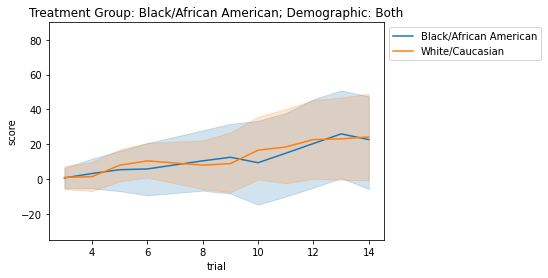

In [23]:
plt.title('Treatment Group: Black/African American; Demographic: Both')
plt.ylim([-35,90])
sns.lineplot(data=pivot_gBdB,x='trials.thisRepN',y='value',err_style="band",ci=95,label="Black/African American")
sns.lineplot(data=pivot_gBdW,x='trials.thisRepN',y='value',err_style="band",ci=95,label="White/Caucasian")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel('score')
plt.xlabel('trial')
plt.savefig('img/avg_cumulative/gB both demo.svg',bbox_inches='tight')

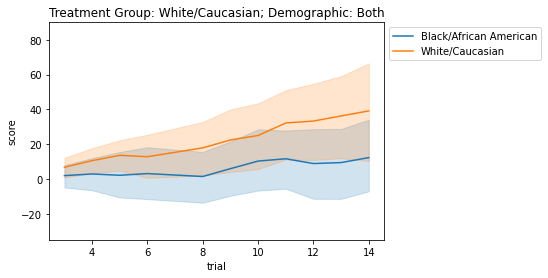

In [24]:
plt.title('Treatment Group: White/Caucasian; Demographic: Both')
plt.ylim([-35,90])
sns.lineplot(data=pivot_gWdB,x='trials.thisRepN',y='value',err_style="band",ci=95,label="Black/African American")
sns.lineplot(data=pivot_gWdW,x='trials.thisRepN',y='value',err_style="band",ci=95,label="White/Caucasian")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel('score')
plt.xlabel('trial')
plt.savefig('img/avg_cumulative/gW both demo.svg',bbox_inches='tight')

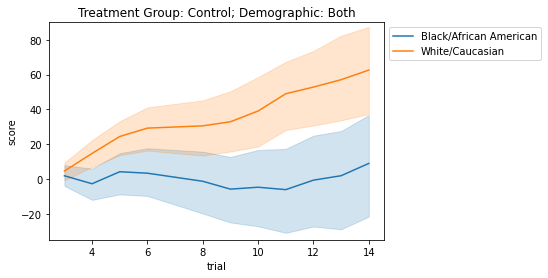

In [104]:
plt.title('Treatment Group: Control; Demographic: Both')
plt.ylim([-35,90])
sns.lineplot(data=pivot_gGdB,x='trials.thisRepN',y='value',err_style="band",ci=95,label="Black/African American")
sns.lineplot(data=pivot_gGdW,x='trials.thisRepN',y='value',err_style="band",ci=95,label="White/Caucasian")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel('score')
plt.xlabel('trial')
plt.savefig('img/avg_cumulative/gG both demo.svg',bbox_inches='tight')

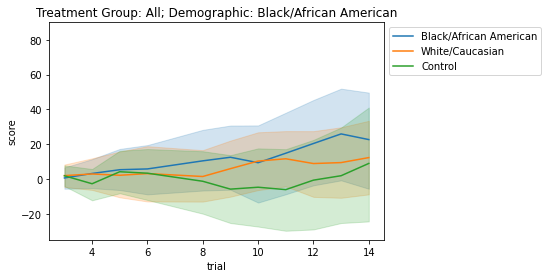

In [105]:
plt.title('Treatment Group: All; Demographic: Black/African American')
plt.ylim([-35,90])
sns.lineplot(data=pivot_gBdB,x='trials.thisRepN',y='value',err_style="band",ci=95,label="Black/African American")
sns.lineplot(data=pivot_gWdB,x='trials.thisRepN',y='value',err_style="band",ci=95,label="White/Caucasian")
sns.lineplot(data=pivot_gGdB,x='trials.thisRepN',y='value',err_style="band",ci=95,label="Control")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel('score')
plt.xlabel('trial')
plt.savefig('img/avg_cumulative/gAlldB.svg',bbox_inches='tight')

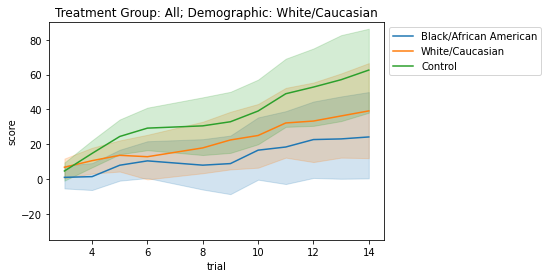

In [106]:
plt.title('Treatment Group: All; Demographic: White/Caucasian')
plt.ylim([-35,90])
sns.lineplot(data=pivot_gBdW,x='trials.thisRepN',y='value',err_style="band",ci=95,label="Black/African American")
sns.lineplot(data=pivot_gWdW,x='trials.thisRepN',y='value',err_style="band",ci=95,label="White/Caucasian")
sns.lineplot(data=pivot_gGdW,x='trials.thisRepN',y='value',err_style="band",ci=95,label="Control")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel('score')
plt.xlabel('trial')
plt.savefig('img/avg_cumulative/gAlldW.svg',bbox_inches='tight')

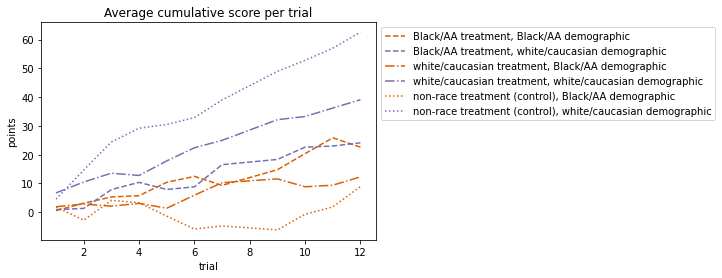

In [28]:
plt.plot(x_vals,avg_tot_gBdB, label='Black/AA treatment, Black/AA demographic',linestyle='--',color='#d95f02')
plt.plot(x_vals,avg_tot_gBdW, label='Black/AA treatment, white/caucasian demographic',linestyle='--',color='#7570b3')
plt.plot(x_vals,avg_tot_gWdB, label='white/caucasian treatment, Black/AA demographic',linestyle='-.',color='#d95f02')
plt.plot(x_vals,avg_tot_gWdW, label='white/caucasian treatment, white/caucasian demographic',linestyle='-.',color='#7570b3')
plt.plot(x_vals,avg_tot_gGdB, label='non-race treatment (control), Black/AA demographic',linestyle=':',color='#d95f02')
plt.plot(x_vals,avg_tot_gGdW, label='non-race treatment (control), white/caucasian demographic',linestyle=':',color='#7570b3')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Average cumulative score per trial')
plt.ylabel('points')
plt.xlabel('trial')
plt.savefig('img/avg_cumulative/avg_cumulative_all.tiff',bbox_inches='tight')

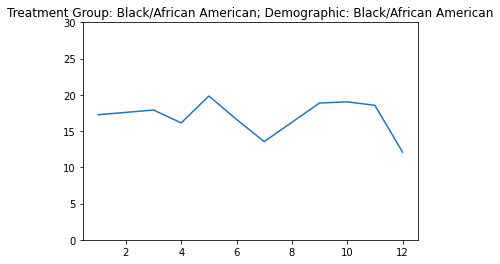

In [29]:
#Averaging score per trial (non-cumulative)
def avg_each_trial(data):
    out_dict = {}
    avg_trial = []
    for i,row in data.iterrows():
        trial = row['trials.thisRepN']
        score = row['value']
        if trial in out_dict:
            out_dict[trial].append(score)
        else:
            out_dict[trial] = [score]
    for key in out_dict:
        avg_trial.append(np.mean(out_dict[key]))
    return avg_trial

avg_gBdB = avg_each_trial(score_gBdB)
avg_gBdW = avg_each_trial(score_gBdW)
avg_gWdB = avg_each_trial(score_gWdB)
avg_gWdW = avg_each_trial(score_gWdW)
avg_gGdB = avg_each_trial(score_gGdB)
avg_gGdW = avg_each_trial(score_gGdW)
plt.plot(x_vals,avg_gBdB)
plt.ylim([0,30])
plt.title('Treatment Group: Black/African American; Demographic: Black/African American')
plt.savefig('img/avg_per_trial/gBdB.svg',bbox_inches='tight')

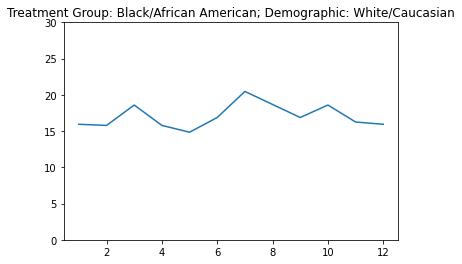

In [30]:
plt.plot(x_vals,avg_gBdW)
plt.ylim([0,30])
plt.title('Treatment Group: Black/African American; Demographic: White/Caucasian')
plt.savefig('img/avg_per_trial/gBdW.svg',bbox_inches='tight')

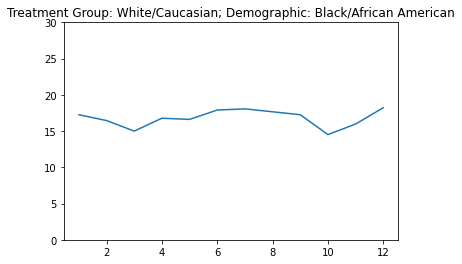

In [31]:
plt.plot(x_vals,avg_gWdB)
plt.ylim([0,30])
plt.title('Treatment Group: White/Caucasian; Demographic: Black/African American')
plt.savefig('img/avg_per_trial/gWdB.svg',bbox_inches='tight')

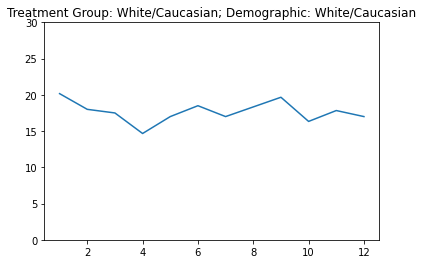

In [32]:
plt.plot(x_vals,avg_gWdW)
plt.ylim([0,30])
plt.title('Treatment Group: White/Caucasian; Demographic: White/Caucasian')
plt.savefig('img/avg_per_trial/gWdW.svg',bbox_inches='tight')

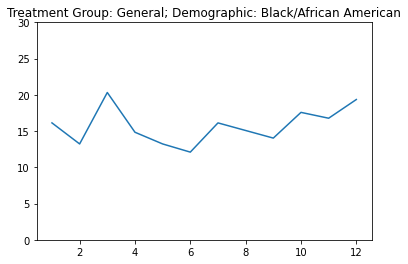

In [33]:
plt.plot(x_vals,avg_gGdB)
plt.ylim([0,30])
plt.title('Treatment Group: General; Demographic: Black/African American')
plt.savefig('img/avg_per_trial/gGdB.svg',bbox_inches='tight')

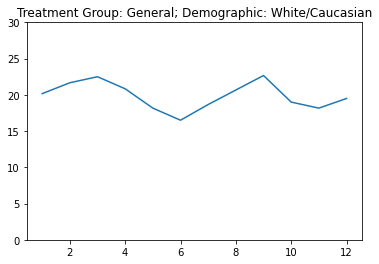

In [34]:
plt.plot(x_vals,avg_gGdW)
plt.ylim([0,30])
plt.title('Treatment Group: General; Demographic: White/Caucasian')
plt.savefig('img/avg_per_trial/gGdW.svg',bbox_inches='tight')

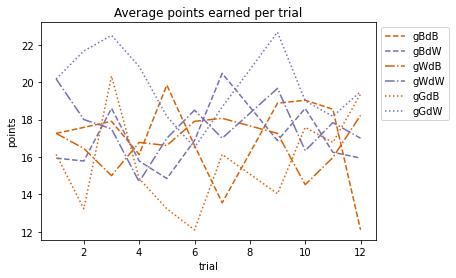

In [35]:
#This begins the most useful graphs of the pavlovia data, colors chosen from an accessible palate
plt.plot(x_vals,avg_gBdB, label='gBdB',linestyle='--',color='#d95f02')
plt.plot(x_vals,avg_gBdW, label='gBdW',linestyle='--',color='#7570b3')
plt.plot(x_vals,avg_gWdB, label='gWdB',linestyle='-.',color='#d95f02')
plt.plot(x_vals,avg_gWdW, label='gWdW',linestyle='-.',color='#7570b3')
plt.plot(x_vals,avg_gGdB, label='gGdB',linestyle=':',color='#d95f02')
plt.plot(x_vals,avg_gGdW, label='gGdW',linestyle=':',color='#7570b3')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Average points earned per trial')
plt.ylabel('points')
plt.xlabel('trial')
plt.savefig('img/avg_per_trial/all.svg',bbox_inches='tight')

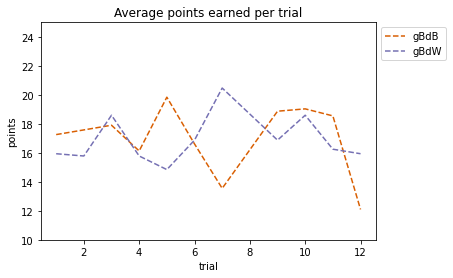

In [36]:
plt.plot(x_vals,avg_gBdB, label='gBdB',linestyle='--',color='#d95f02')
plt.plot(x_vals,avg_gBdW, label='gBdW',linestyle='--',color='#7570b3')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Average points earned per trial')
plt.ylabel('points')
plt.xlabel('trial')
plt.ylim([10,25])
plt.savefig('img/avg_per_trial/black_treatment.svg',bbox_inches='tight')

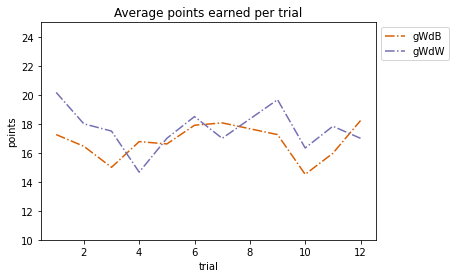

In [37]:
plt.plot(x_vals,avg_gWdB, label='gWdB',linestyle='-.',color='#d95f02')
plt.plot(x_vals,avg_gWdW, label='gWdW',linestyle='-.',color='#7570b3')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Average points earned per trial')
plt.ylabel('points')
plt.xlabel('trial')
plt.ylim([10,25])
plt.savefig('img/avg_per_trial/white_treatment.svg',bbox_inches='tight')

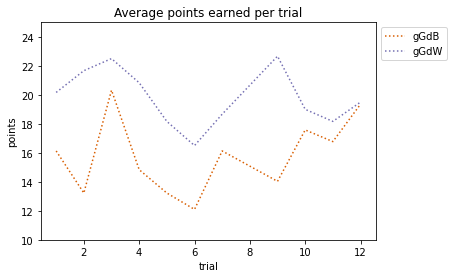

In [38]:
plt.plot(x_vals,avg_gGdB, label='gGdB',linestyle=':',color='#d95f02')
plt.plot(x_vals,avg_gGdW, label='gGdW',linestyle=':',color='#7570b3')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Average points earned per trial')
plt.ylabel('points')
plt.xlabel('trial')
plt.ylim([10,25])
plt.savefig('img/avg_per_trial/general_treatment.svg',bbox_inches='tight')

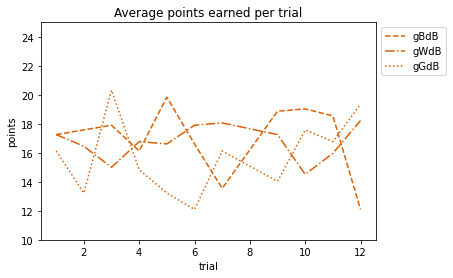

In [39]:
plt.plot(x_vals,avg_gBdB, label='gBdB',linestyle='--',color='#d95f02')
plt.plot(x_vals,avg_gWdB, label='gWdB',linestyle='-.',color='#d95f02')
plt.plot(x_vals,avg_gGdB, label='gGdB',linestyle=':',color='#d95f02')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Average points earned per trial')
plt.ylabel('points')
plt.xlabel('trial')
plt.ylim([10,25])
plt.savefig('img/avg_per_trial/black_demographic.svg',bbox_inches='tight')

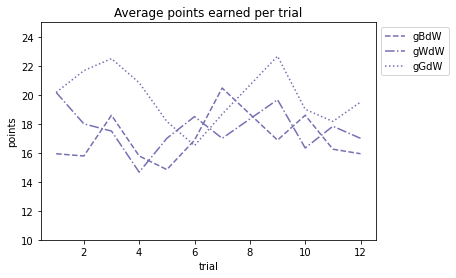

In [40]:
plt.plot(x_vals,avg_gBdW, label='gBdW',linestyle='--',color='#7570b3')
plt.plot(x_vals,avg_gWdW, label='gWdW',linestyle='-.',color='#7570b3')
plt.plot(x_vals,avg_gGdW, label='gGdW',linestyle=':',color='#7570b3')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Average points earned per trial')
plt.ylabel('points')
plt.xlabel('trial')
plt.ylim([10,25])
plt.savefig('img/avg_per_trial/white_treatment.svg',bbox_inches='tight')

In [41]:
#This gets counts of each scoring method
def prop_scoring_action(data):
    out_dict = {}
    for i,row in data.iterrows():
        method = row['Method of Scoring']
        if method in out_dict:
            out_dict[method] += 1
        else:
            out_dict[method] = 1
    return out_dict
prop_gBdB = prop_scoring_action(method_gBdB)
prop_gBdW = prop_scoring_action(method_gBdW)
prop_gWdB = prop_scoring_action(method_gWdB)
prop_gWdW = prop_scoring_action(method_gWdW)
prop_gGdB = prop_scoring_action(method_gGdB)
prop_gGdW = prop_scoring_action(method_gGdW)

def is_first_trial(row):
    if row['trials.thisN']==3:
        return True
    else:
        return False

#counting average number of moves per scoring method
def count_moves(data):
    exit_counts = []
    captured_counts = []
    no_points_counts = []
    timed_counts = []
    moves_count = 0
    prev_score = 0
    for i,row in data.iterrows():
        method = row['Method of Scoring']
        if method == 'No points scored':
            if is_first_trial(row):
                moves_count = abs(row['Score'])
            else:
                moves_count = abs(row['Score'] - prev_score)
            no_points_counts.append(moves_count)
        elif method == 'captured pig':
            if is_first_trial(row):
                moves_count = abs(row['Score'] - row['value'])
            else:
                moves_count = abs(row['Score'] - row['value'] - prev_score)
            captured_counts.append(moves_count)
        elif method == 'Exited through black block':
            if is_first_trial(row):
                moves_count = abs(row['Score'] - row['value'])
            else:
                moves_count = abs(row['Score'] - row['value'] - prev_score)
            exit_counts.append(moves_count)
        elif method == 'Timed Out':
            timed_counts = moves_count
        else:
            print('something wrong')
        prev_score = row['Score']
    return list((np.mean(exit_counts), np.mean(captured_counts), np.mean(no_points_counts),np.mean(timed_counts)))

def move_CIs(data):
    counts = []
    exit_counts = []
    captured_counts = []
    no_points_counts = []
    timed_counts = []
    CIs = []
    moves_count = 0
    prev_score = 0
    for i,row in data.iterrows():
        method = row['Method of Scoring']
        if method == 'No points scored':
            if is_first_trial(row):
                moves_count = abs(row['Score'])
            else:
                moves_count = abs(row['Score'] - prev_score)
            no_points_counts.append(moves_count)
        elif method == 'captured pig':
            if is_first_trial(row):
                moves_count = abs(row['Score'] - row['value'])
            else:
                moves_count = abs(row['Score'] - row['value'] - prev_score)
            captured_counts.append(moves_count)
        elif method == 'Exited through black block':
            if is_first_trial(row):
                moves_count = abs(row['Score'] - row['value'])
            else:
                moves_count = abs(row['Score'] - row['value'] - prev_score)
            exit_counts.append(moves_count)
        elif method == 'Timed Out':
            timed_counts = moves_count
        else:
            print('something wrong')
        prev_score = row['Score']
    counts.append([exit_counts])
    counts.append([captured_counts])
    counts.append([no_points_counts])
    counts.append([timed_counts])
    for count in counts:
        hi = (np.mean(count) + 1.96*np.std(count)/math.sqrt(len(count)))
        lo = (np.mean(count) - 1.96*np.std(count)/math.sqrt(len(count)))
        CIs.append("["+"{:.2f}".format(lo) + ","+ "{:.2f}".format(hi)+"]")
    return CIs
# need to come back to this and remove some redundancies
moves_headers = ['Treatment Group','Demographic', 'Exited', 'Captured Pig', 'No Points','Timed Out']
moves_output = []
CIs_output = []
moves_output.append(['Black/African American','Black/African American']+count_moves(method_gBdB))
moves_output.append(['Black/African American','White/Caucasian']+count_moves(method_gBdW))
moves_output.append(['White/Caucasian','Black/African American']+count_moves(method_gWdB))
moves_output.append(['White/Caucasian','White/Caucasian']+count_moves(method_gWdW))
moves_output.append(['General','Black/African American']+count_moves(method_gGdB))
moves_output.append(['General','White/Caucasian']+count_moves(method_gGdW))
print('Average number of moves per trial per scoring method')
print(tabulate(moves_output,moves_headers,tablefmt='github',floatfmt=".2f"))

CIs_output.append(['Black/African American','Black/African American']+move_CIs(method_gBdB))
CIs_output.append(['Black/African American','White/Caucasian']+move_CIs(method_gBdW))
CIs_output.append(['White/Caucasian','Black/African American']+move_CIs(method_gWdB))
CIs_output.append(['White/Caucasian','White/Caucasian']+move_CIs(method_gWdW))
CIs_output.append(['General','Black/African American']+move_CIs(method_gGdB))
CIs_output.append(['General','White/Caucasian']+move_CIs(method_gGdW))
print('95% Confidence Intervals for average number of moves per scoring method')
print(tabulate(CIs_output,moves_headers,tablefmt='github'))

Average number of moves per trial per scoring method
| Treatment Group        | Demographic            |   Exited |   Captured Pig |   No Points |   Timed Out |
|------------------------|------------------------|----------|----------------|-------------|-------------|
| Black/African American | Black/African American |    14.22 |          11.70 |       25.24 |      nan    |
| Black/African American | White/Caucasian        |    14.30 |          11.36 |       24.93 |        7.00 |
| White/Caucasian        | Black/African American |    16.78 |          12.03 |       24.88 |      nan    |
| White/Caucasian        | White/Caucasian        |    16.28 |          10.91 |       24.60 |      nan    |
| General                | Black/African American |    13.40 |          11.10 |       25.61 |      nan    |
| General                | White/Caucasian        |    18.59 |          11.73 |       24.22 |       21.00 |
95% Confidence Intervals for average number of moves per scoring method
| Treatment

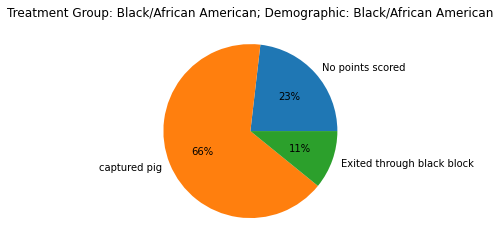

In [42]:
plt.pie(prop_gBdB.values(),labels = prop_gBdB.keys(),autopct='%1.f%%')
plt.title('Treatment Group: Black/African American; Demographic: Black/African American')
plt.savefig('img/scoring_method/gBdB.svg',bbox_inches='tight')

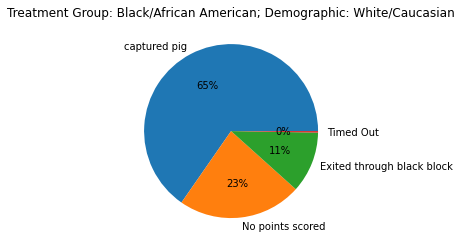

In [43]:
plt.pie(prop_gBdW.values(),labels = prop_gBdW.keys(),autopct='%1.f%%')
plt.title('Treatment Group: Black/African American; Demographic: White/Caucasian')
plt.savefig('img/scoring_method/gBdW.svg',bbox_inches='tight')

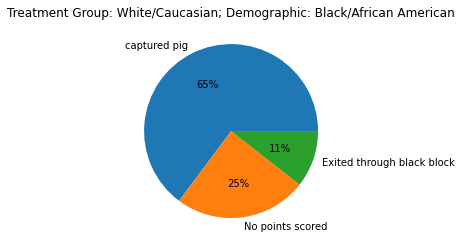

In [44]:
plt.pie(prop_gWdB.values(),labels = prop_gWdB.keys(),autopct='%1.f%%')
plt.title('Treatment Group: White/Caucasian; Demographic: Black/African American')
plt.savefig('img/scoring_method/gWdB.svg',bbox_inches='tight')

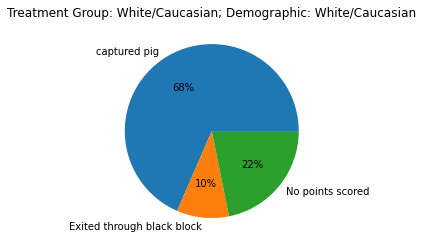

In [45]:
plt.pie(prop_gWdW.values(),labels = prop_gWdW.keys(),autopct='%1.f%%')
plt.title('Treatment Group: White/Caucasian; Demographic: White/Caucasian')
plt.savefig('img/scoring_method/gWdW.svg',bbox_inches='tight')

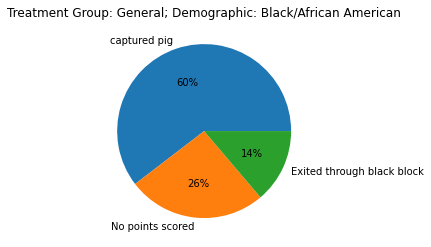

In [46]:
plt.pie(prop_gGdB.values(),labels = prop_gGdB.keys(),autopct='%1.f%%')
plt.title('Treatment Group: General; Demographic: Black/African American')
plt.savefig('img/scoring_method/gGdB.svg',bbox_inches='tight')

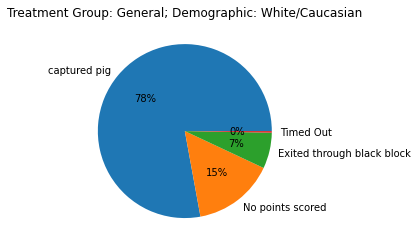

In [47]:
plt.pie(prop_gGdW.values(),labels = prop_gGdW.keys(),autopct='%1.f%%')
plt.title('Treatment Group: General; Demographic: White/Caucasian')
plt.savefig('img/scoring_method/gGdW.svg',bbox_inches='tight')

In [48]:
qualtrics_part2_file = glob.glob('data/Qualtrics/part2/*.csv')

In [49]:
qualtrics_part2 = pd.read_csv(qualtrics_part2_file[0])
qualtrics_part2.dtypes
qualtrics_part2['Q11_1']= pd.to_numeric(qualtrics_part2['Q11_1'][2:])
qualtrics_part2.dtypes

StartDate                 object
EndDate                   object
Status                    object
IPAddress                 object
Progress                  object
Duration (in seconds)     object
Finished                  object
RecordedDate              object
ResponseId                object
RecipientLastName         object
RecipientFirstName        object
RecipientEmail            object
ExternalReference         object
LocationLatitude          object
LocationLongitude         object
DistributionChannel       object
UserLanguage              object
Q1                        object
Q2                        object
Q11_1                    float64
Q16                       object
Q19                       object
PROLIFIC_PID              object
STUDY_ID                  object
SESSION_ID                object
dtype: object

In [50]:
qualtrics_part1_files = glob.glob('data/Qualtrics/part1/*.csv')
qualtrics_part1 = pd.read_csv(qualtrics_part1_files[0])

In [51]:
i = 1
while i < len(qualtrics_part1_files):
    print(i ,"." ,qualtrics_part1_files[i])
    temp = pd.read_csv(qualtrics_part1_files[i])
    qualtrics_part1 = pd.concat([qualtrics_part1, temp], ignore_index = True)
    i+=1

1 . data/Qualtrics/part1/Human-AI Exp response confirmations - Qualtrics Part 1.csv


In [52]:
# qualtrics_part1

In [53]:
combined = qualtrics_part1.set_index('PROLIFIC_PID').join(qualtrics_part2.set_index('PROLIFIC_PID'),lsuffix='_part1',rsuffix='part2')

In [54]:
# combined

In [55]:
prolific.rename({'participant_id' : 'PROLIFIC_PID'}, inplace=True)
prolific_qualtrics_combined = pd.merge(prolific, qualtrics_part2, on='PROLIFIC_PID',how='left')
prolific_qualtrics_combined.drop_duplicates(subset=['PROLIFIC_PID'], keep='last',inplace=True)

In [56]:
prolific_qualtrics_combined.to_csv('human-ai-combined.csv')

In [57]:
list(prolific_qualtrics_combined)

['Ready to Approve and Pay',
 'PROLIFIC_PID',
 'session_id',
 'status',
 'started_datetime',
 'completed_date_time',
 'time_taken',
 'age',
 'num_approvals',
 'num_rejections',
 'prolific_score',
 'reviewed_at_datetime',
 'entered_code',
 'Country of Birth',
 'Current Country of Residence',
 'Employment Status',
 'First Language',
 'Nationality',
 'Sex',
 'Student Status',
 'Demographic',
 'GROUP',
 'Unnamed: 22',
 'Unnamed: 23',
 'Unnamed: 24',
 'Unnamed: 25',
 'Unnamed: 26',
 'Unnamed: 27',
 'Unnamed: 28',
 'StartDate',
 'EndDate',
 'Status',
 'IPAddress',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'RecordedDate',
 'ResponseId',
 'RecipientLastName',
 'RecipientFirstName',
 'RecipientEmail',
 'ExternalReference',
 'LocationLatitude',
 'LocationLongitude',
 'DistributionChannel',
 'UserLanguage',
 'Q1',
 'Q2',
 'Q11_1',
 'Q16',
 'Q19',
 'STUDY_ID',
 'SESSION_ID']

In [58]:
to_drop = ['STUDY_ID',
 'SESSION_ID',
 'Unnamed: 22',
 'Unnamed: 23',
 'Unnamed: 24',
 'StartDate',
 'EndDate',
 'Status',
 'IPAddress',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'RecordedDate',
 'ResponseId',
 'RecipientLastName',
 'RecipientFirstName',
 'RecipientEmail',
 'ExternalReference',
 'LocationLatitude',
 'LocationLongitude',
 'DistributionChannel',
 'UserLanguage',
 'session_id',
 'status',
 'Ready to Approve and Pay',
 'completed_date_time',
 'time_taken',
 'num_approvals',
 'num_rejections',
 'prolific_score',
 'reviewed_at_datetime',
 'entered_code',
 'Country of Birth',
 'Current Country of Residence',
 'Employment Status',
 'First Language',
 'Nationality',
 'Student Status']

prolific_qualtrics_combined.drop(to_drop, inplace=True,axis=1)

In [59]:
prolific_qualtrics_combined_final = prolific_qualtrics_combined.loc[(prolific_qualtrics_combined.Demographic!='CONSENT REVOKED')]
prolific_qualtrics_combined_final.dropna(subset=['Q11_1'],inplace=True)
prolific_qualtrics_combined_final.to_csv('human-ai-combined.csv')

In [60]:
#All of this data analysis on the intelligence scores ended not being super useful, future runs of this study might use it though so I'm leaving it in here
stats = prolific_qualtrics_combined_final[["GROUP","Demographic","Q11_1"]].groupby(["GROUP","Demographic"]).agg(['mean','median','count','std'])
# print(stats)
print('-'*30)
ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, med, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)

------------------------------
                                                Q11_1                          \
                                                 mean median count        std   
GROUP               Demographic                                                 
Black               Black/African American  57.741935   60.0    31  27.580147   
                    White/Caucasian         50.419355   52.0    31  27.935371   
General             Black/African American  51.419355   64.0    31  31.478854   
                    White/Caucasian         51.677419   60.0    31  26.885420   
General/Black       Black/African American  68.000000   65.0     3  30.610456   
                    White/Caucasian         62.400000   60.0     5  18.406521   
General/White       Black/African American  70.500000   70.5     2  41.719300   
                    White/Caucasian         23.500000   23.5     2  12.020815   
General/White/Black White/Caucasian         46.000000   46.0     1        NaN 

<AxesSubplot:xlabel='age', ylabel='Intelligence ranking'>

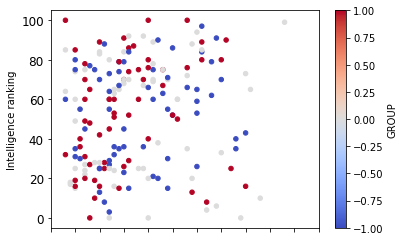

In [61]:
scatter_data=prolific_qualtrics_combined_final.loc[((prolific_qualtrics_combined_final.GROUP =='General')|(prolific_qualtrics_combined_final.GROUP =='Black')|(prolific_qualtrics_combined_final.GROUP =='White'))]
remap={'General':0,'Black':1,'White':-1}
scatter_data.replace({'GROUP':remap},inplace=True)
scatter_data.plot(kind='scatter',x='age',y='Q11_1',c='GROUP',colormap='coolwarm',ylabel="Intelligence ranking",xlabel='age',fontsize=12,xticks=[15,20,25,30,35,40,45,50,55,60,65,70])

In [62]:
print(prolific_qualtrics_combined_final[["GROUP","Demographic","Q11_1"]].groupby(["GROUP","Demographic"]).median())

                                            Q11_1
GROUP               Demographic                  
Black               Black/African American   60.0
                    White/Caucasian          52.0
General             Black/African American   64.0
                    White/Caucasian          60.0
General/Black       Black/African American   65.0
                    White/Caucasian          60.0
General/White       Black/African American   70.5
                    White/Caucasian          23.5
General/White/Black White/Caucasian          46.0
White               Black/African American   60.0
                    White/Caucasian          55.0


In [63]:
print(prolific_qualtrics_combined_final[["GROUP","Demographic","Q11_1"]].groupby(["GROUP","Demographic"]).count())

                                            Q11_1
GROUP               Demographic                  
Black               Black/African American     31
                    White/Caucasian            31
General             Black/African American     31
                    White/Caucasian            31
General/Black       Black/African American      3
                    White/Caucasian             5
General/White       Black/African American      2
                    White/Caucasian             2
General/White/Black White/Caucasian             1
White               Black/African American     31
                    White/Caucasian            31


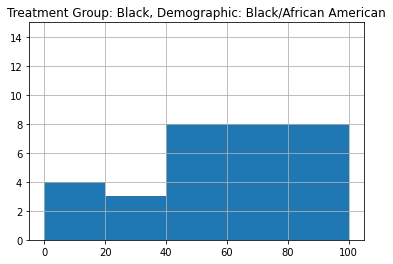

In [64]:
g_Black_d_Black = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='Black')&(prolific_qualtrics_combined_final.Demographic == 'Black/African American')]
datagBdB = g_Black_d_Black['Q11_1']
fig=datagBdB.hist(bins=[0,20,40,60,80,100],grid=1)
fig.set_title('Treatment Group: Black, Demographic: Black/African American')
fig.set_ylim([0,15])
fig=fig.get_figure()
fig.savefig('img/intelligence_rating_hist/gBdB_hist5.svg')

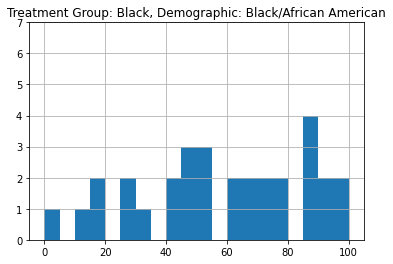

In [65]:
fig1 = datagBdB.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],grid=1)
fig1.set_title('Treatment Group: Black, Demographic: Black/African American')
fig1.set_ylim([0,7])
fig1=fig1.get_figure()
fig1.savefig('img/intelligence_rating_hist/gBdB_hist20.svg')



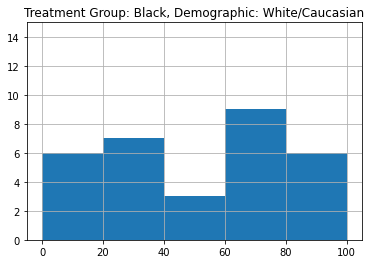

In [66]:
g_Black_d_White = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='Black')&(prolific_qualtrics_combined_final.Demographic == 'White/Caucasian')]
datagBdW = g_Black_d_White['Q11_1']
fig = datagBdW.hist(bins=[0,20,40,60,80,100],grid=1)
fig.set_title('Treatment Group: Black, Demographic: White/Caucasian')
fig.set_ylim([0,15])
fig=fig.get_figure()
fig.savefig('img/intelligence_rating_hist/gBdW_hist5.svg')


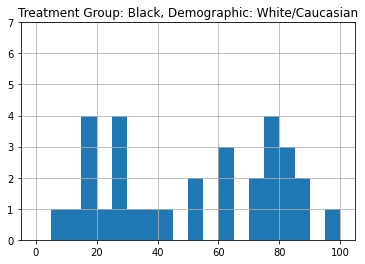

In [67]:
fig1 = datagBdW.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],grid=1)
fig1.set_title('Treatment Group: Black, Demographic: White/Caucasian')
fig1.set_ylim([0,7])
fig1=fig1.get_figure()
fig1.savefig('img/intelligence_rating_hist/gBdW_hist20.svg')


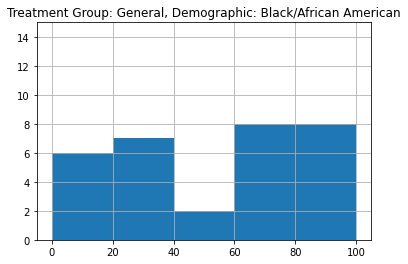

In [68]:
g_General_d_Black = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='General')&(prolific_qualtrics_combined_final.Demographic == 'Black/African American')]
datagGdB = g_General_d_Black['Q11_1']
fig = datagGdB.hist(bins=[0,20,40,60,80,100],grid=1)
fig.set_title('Treatment Group: General, Demographic: Black/African American')
fig.set_ylim([0,15])
fig=fig.get_figure()
fig.savefig('img/intelligence_rating_hist/gGdB_hist5.svg')


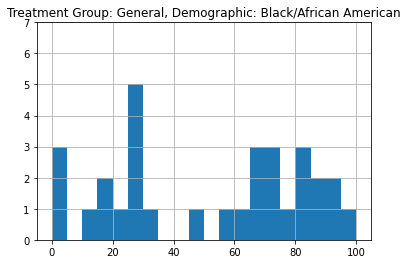

In [69]:
fig1 = datagGdB.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],grid=1)
fig1.set_title('Treatment Group: General, Demographic: Black/African American')
fig1.set_ylim([0,7])
fig1=fig1.get_figure()
fig1.savefig('img/intelligence_rating_hist/gGdB_hist20.svg')

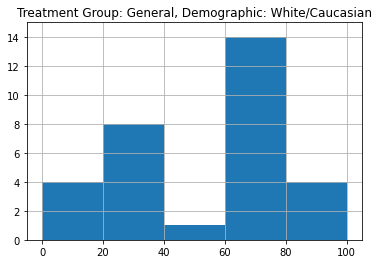

In [70]:
g_General_d_White = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='General')&(prolific_qualtrics_combined_final.Demographic == 'White/Caucasian')]
datagGdW = g_General_d_White['Q11_1']
fig = datagGdW.hist(bins=[0,20,40,60,80,100],grid=1)
fig.set_title('Treatment Group: General, Demographic: White/Caucasian')
fig.set_ylim([0,15])
fig=fig.get_figure()
fig.savefig('img/intelligence_rating_hist/gGdW_hist5.svg')

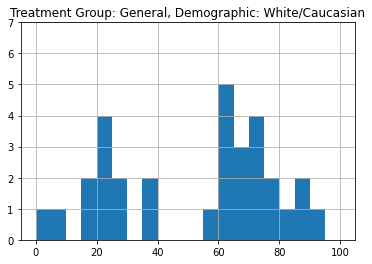

In [71]:
fig1 = datagGdW.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],grid=1)
fig1.set_title('Treatment Group: General, Demographic: White/Caucasian')
fig1.set_ylim([0,7])
fig1=fig1.get_figure()
fig1.savefig('img/intelligence_rating_hist/gGWB_hist20.svg')

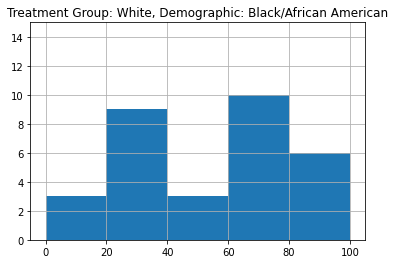

In [72]:
g_White_d_Black = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='White')&(prolific_qualtrics_combined_final.Demographic == 'Black/African American')]
datagWdB = g_White_d_Black['Q11_1']
fig = datagWdB.hist(bins=[0,20,40,60,80,100],grid=1)
fig.set_title('Treatment Group: White, Demographic: Black/African American')
fig.set_ylim([0,15])
fig=fig.get_figure()
fig.savefig('img/intelligence_rating_hist/gWdB_hist5.svg')

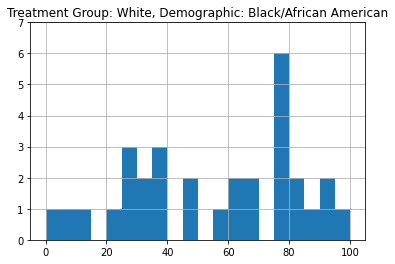

In [73]:
fig1 = datagWdB.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],grid=1)
fig1.set_title('Treatment Group: White, Demographic: Black/African American')
fig1.set_ylim([0,7])
fig1=fig1.get_figure()
fig1.savefig('img/intelligence_rating_hist/gWdB_hist20.svg')

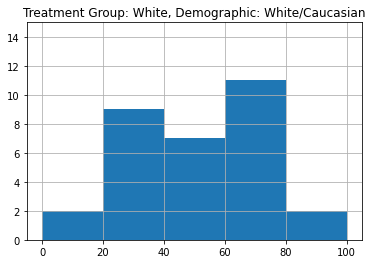

In [74]:
g_White_d_White = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='White')&(prolific_qualtrics_combined_final.Demographic == 'White/Caucasian')]
datagWdW = g_White_d_White['Q11_1']
fig = datagWdW.hist(bins=[0,20,40,60,80,100],grid=1)
fig.set_title('Treatment Group: White, Demographic: White/Caucasian')
fig.set_ylim([0,15])
fig=fig.get_figure()
fig.savefig('img/intelligence_rating_hist/gWdW_hist5.svg')

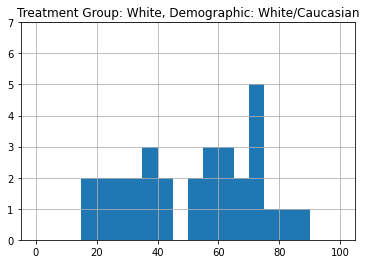

In [75]:
fig1 = datagWdW.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],grid=1)
fig1.set_title('Treatment Group: White, Demographic: White/Caucasian')
fig1.set_ylim([0,7])
fig1=fig1.get_figure()
fig1.savefig('img/intelligence_rating_hist/gWdW_hist20.svg')

In [76]:
#ANOVA
fvalue, pvalue = stat.f_oneway(g_Black_d_Black['Q11_1'], g_Black_d_White['Q11_1'], g_White_d_Black['Q11_1'], g_White_d_White['Q11_1'], g_General_d_Black['Q11_1'], g_General_d_White['Q11_1'])
print('f-val:',fvalue,'p-val:' ,pvalue)

f-val: 0.342694291875433 p-val: 0.8864312198231169


In [77]:
pivoted_data_anova = pd.melt(prolific_qualtrics_combined_final, id_vars=['GROUP','Demographic'], value_vars=['Q11_1'])

In [78]:
pivoted_data_anova.drop('variable',inplace=True,axis=1)

In [79]:
pivoted_data_anova = pivoted_data_anova.loc[((pivoted_data_anova.GROUP=='Black')|(pivoted_data_anova.GROUP=='White')|(pivoted_data_anova.GROUP=='General'))]
pivoted_data_anova.dropna(axis=0,inplace=True)
pivoted_data_anova


,GROUP,Demographic,value
0,White,White/Caucasian,21.0
1,White,White/Caucasian,52.0
2,General,White/Caucasian,65.0
3,Black,White/Caucasian,70.0
4,White,White/Caucasian,36.0
5,General,White/Caucasian,15.0
6,White,White/Caucasian,15.0
7,Black,White/Caucasian,36.0
8,Black,White/Caucasian,70.0
9,White,White/Caucasian,70.0


In [80]:
model = ols('value ~ C(GROUP) + C(Demographic) + C(GROUP):C(Demographic)', data=pivoted_data_anova).fit()
result = sm.stats.anova_lm(model, typ=2)
print(result)

                                sum_sq     df         F    PR(>F)
C(GROUP)                    201.709677    2.0  0.135654  0.873234
C(Demographic)              625.166667    1.0  0.840874  0.360374
C(GROUP):C(Demographic)     447.043011    2.0  0.300645  0.740711
Residual                 133825.096774  180.0       NaN       NaN


In [81]:
g_Black = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='Black')]
print(pg.kruskal(data=g_Black,dv='Q11_1',between='Demographic'))

              Source  ddof1         H     p-unc
Kruskal  Demographic      1  1.086554  0.297236


In [82]:
g_General = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='General')]
print(pg.kruskal(data=g_General,dv='Q11_1',between='Demographic'))

              Source  ddof1         H     p-unc
Kruskal  Demographic      1  0.071634  0.788973


In [82]:
g_White = prolific_qualtrics_combined_final.loc[(prolific_qualtrics_combined_final.GROUP =='White')]
print(pg.kruskal(data=g_White,dv='Q11_1',between='Demographic'))

              Source  ddof1         H     p-unc
Kruskal  Demographic      1  0.787236  0.374937


In [83]:
print(pg.kruskal(data=prolific_qualtrics_combined_final.loc[((prolific_qualtrics_combined_final.GROUP =='General')|(prolific_qualtrics_combined_final.GROUP =='Black')|(prolific_qualtrics_combined_final.GROUP =='White'))],dv='Q11_1',between='GROUP'))

        Source  ddof1         H     p-unc
Kruskal  GROUP      2  0.276182  0.871019
